In [116]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor,ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.svm import NuSVR
from sklearn.linear_model import SGDRegressor
from sklearn.decomposition import PCA
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 1000)
plt.rcParams['figure.figsize'] = (17.0, 7.0)
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

<h3> Reading data

In [2]:
train_data = pd.read_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Train_xyqdbho.csv")
test_data = pd.read_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Test_pyI9Owa.csv")

<h3> Feature generation

In [3]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['year'] = train_data['Date'].map(lambda x : x.year)
train_data['month'] = train_data['Date'].map(lambda x : x.month)
train_data['day'] = train_data['Date'].map(lambda x : x.day)
train_data['Day_of_week'] = train_data['Date'].map(lambda x: x.weekday())
train_data['quarter'] = train_data['Date'].map(lambda x: x.quarter)
train_data['Weekday'] = train_data['Day_of_week'].map(lambda x: 0 if x<5 else 1)

test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data['year'] = test_data['Date'].map(lambda x : x.year)
test_data['month'] = test_data['Date'].map(lambda x : x.month)
test_data['day'] = test_data['Date'].map(lambda x : x.day)
test_data['Day_of_week'] = test_data['Date'].map(lambda x: x.weekday())
test_data['quarter'] = test_data['Date'].map(lambda x: x.quarter)
test_data['Weekday'] = test_data['Day_of_week'].map(lambda x: 0 if x < 5 else 1)
test_data['dayofyear'] = test_data['Date'].map(lambda x: x.dayofyear)
test_data['week'] = test_data['Date'].map(lambda x: x.week)
train_data['dayofyear'] = train_data['Date'].map(lambda x: x.dayofyear)
train_data['week'] = train_data['Date'].map(lambda x: x.week)

In [4]:
footfall_mean = pd.DataFrame(train_data.groupby(['Park_ID','month'])['Footfall'].mean())
footfall_mean.columns = ['Footfall_monthly_mean']
footfall_mean.reset_index(inplace=True)
train_data = train_data.merge(footfall_mean,left_on=['Park_ID','month'],right_on=['Park_ID','month'],how='left')
test_data = test_data.merge(footfall_mean,left_on=['Park_ID','month'],right_on=['Park_ID','month'],how='left')

In [5]:
prediction_df = pd.DataFrame(test_data['ID'])

In [6]:
train_data['Park_Month'] = (train_data['Park_ID'].map(str)+train_data['month'].map(str)).map(int)
test_data['Park_Month'] = (test_data['Park_ID'].map(str)+test_data['month'].map(str)).map(int)
train_data['Park_Day'] = (train_data['Park_ID'].map(str)+train_data['day'].map(str)).map(int)
test_data['Park_Day'] = (test_data['Park_ID'].map(str)+test_data['day'].map(str)).map(int)
train_data['Park_Quarter'] = (train_data['Park_ID'].map(str)+train_data['quarter'].map(str)).map(int)
test_data['Park_Quarter'] = (test_data['Park_ID'].map(str)+test_data['quarter'].map(str)).map(int)
train_data['Park_Weekday'] = (train_data['Park_ID'].map(str)+train_data['Weekday'].map(str)).map(int)
test_data['Park_Weekday'] = (test_data['Park_ID'].map(str)+test_data['Weekday'].map(str)).map(int)
train_data['Park_Day_of_Week'] = (train_data['Park_ID'].map(str)+train_data['Day_of_week'].map(str)).map(int)
test_data['Park_Day_of_Week'] = (test_data['Park_ID'].map(str)+test_data['Day_of_week'].map(str)).map(int)
train_data['Park_Week'] = (train_data['Park_ID'].map(str)+train_data['week'].map(str)).map(int)
test_data['Park_Week'] = (test_data['Park_ID'].map(str)+test_data['week'].map(str)).map(int)
train_data['Park_Day_of_Year'] = (train_data['Park_ID'].map(str)+train_data['dayofyear'].map(str)).map(int)
test_data['Park_Day_of_Year'] = (test_data['Park_ID'].map(str)+test_data['dayofyear'].map(str)).map(int)

In [7]:
train_data['Day_Month'] = (train_data['Park_ID'].map(str)+train_data['day'].map(str)+train_data['month'].map(str)).map(int)
test_data['Day_Month'] = (test_data['Park_ID'].map(str)+test_data['day'].map(str)+test_data['month'].map(str)).map(int)

In [8]:
train_data['Moisture_Pollution_diff'] = np.abs(train_data['Average_Moisture_In_Park']+train_data['Max_Ambient_Pollution'])/2.0
test_data['Moisture_Pollution_diff'] = np.abs(test_data['Average_Moisture_In_Park']+test_data['Max_Ambient_Pollution'])/2.0

In [9]:
def breeze_category(x):
    if x < 50:
        return 1
    elif x >=50 and x <100:
        return 2
    else:
        return 3

train_data['Breeze_Cat'] = train_data['Average_Breeze_Speed'].map(breeze_category)
test_data['Breeze_Cat'] = test_data['Average_Breeze_Speed'].map(breeze_category)

In [10]:
def var_category(x):
    if x < 90:
        return 1
    else:
        return 2

train_data['Var_Cat'] = train_data['Var1'].map(breeze_category)
test_data['Var_Cat'] = test_data['Var1'].map(breeze_category)

In [11]:
def pollution_category(x):
    if x < 70:
        return 1
    elif x >= 70 and x<175:
        return 2
    elif x>=175 and x<230:
        return 3
    else:
        return 4

train_data['Pollution_Cat'] = train_data['Max_Ambient_Pollution'].map(breeze_category)
test_data['Pollution_Cat'] = test_data['Max_Ambient_Pollution'].map(breeze_category)

In [14]:
month_var_df = pd.DataFrame(train_data.groupby(['month'])['Var1'].mean())
month_var_df.columns = ['Month_Var']
month_var_df.reset_index(inplace=True)
train_data = train_data.merge(month_var_df,how='left',left_on='month',right_on='month')
test_data = test_data.merge(month_var_df,how='left',left_on='month',right_on='month')

In [12]:
train_data['Park_Pollution_Cat'] = (train_data['Park_ID'].map(str)+train_data['Pollution_Cat'].map(str)).map(int)
test_data['Park_Pollution_Cat'] = (test_data['Park_ID'].map(str)+test_data['Pollution_Cat'].map(str)).map(int)
train_data['Park_Var_Cat'] = (train_data['Park_ID'].map(str)+train_data['Var_Cat'].map(str)).map(int)
test_data['Park_Var_Cat'] = (test_data['Park_ID'].map(str)+test_data['Var_Cat'].map(str)).map(int)
train_data['Park_Breeze_Cat'] = (train_data['Park_ID'].map(str)+train_data['Breeze_Cat'].map(str)).map(int)
test_data['Park_Breeze_Cat'] = (test_data['Park_ID'].map(str)+test_data['Breeze_Cat'].map(str)).map(int)


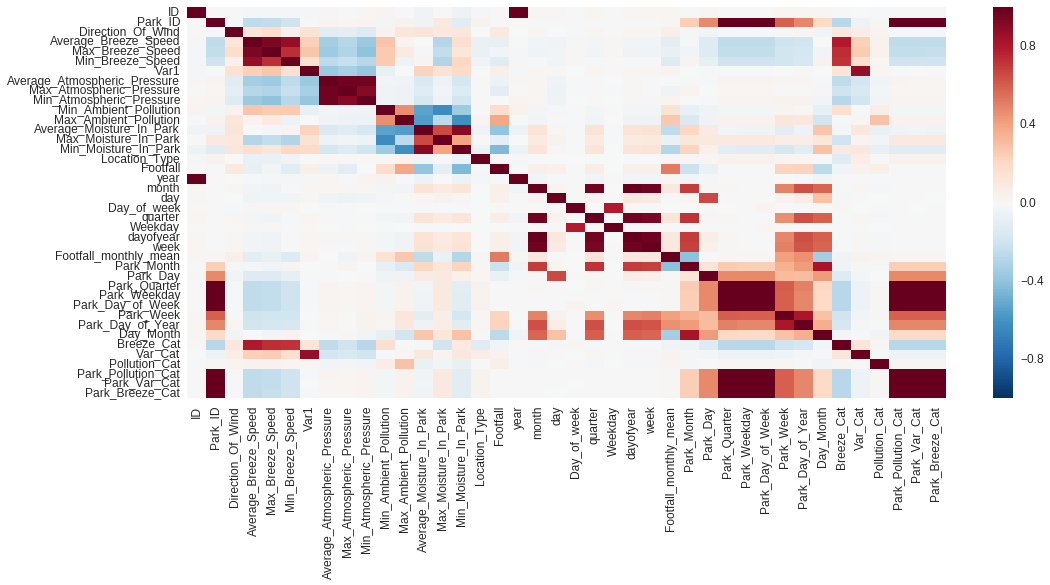

In [12]:
sns.heatmap(train_data.corr())

<h3> Train & Test data preperation

In [74]:
min_max_scaler = preprocessing.MaxAbsScaler()

train_data_baseline = train_data[(train_data['year'] > 1990)][
    ['Park_Month','month','day','Location_Type','Average_Breeze_Speed','Min_Moisture_In_Park',
     'Max_Ambient_Pollution','Direction_Of_Wind','Var1','Min_Ambient_Pollution','Footfall_monthly_mean',
    'Park_Quarter','Park_Week','Park_Day_of_Year','Pollution_Cat']].fillna(0)

train_data_label = train_data[ (train_data['year'] > 1990)]['Footfall']

test_data_baseline = test_data[['Park_Month','month','day','Location_Type','Average_Breeze_Speed',
                               'Min_Moisture_In_Park','Max_Ambient_Pollution','Direction_Of_Wind','Var1',
                               'Min_Ambient_Pollution','Footfall_monthly_mean','Park_Quarter',
                               'Park_Week','Park_Day_of_Year','Pollution_Cat']].fillna(0)

In [75]:
poly = preprocessing.PolynomialFeatures(interaction_only=True)
poly_fit = poly.fit(train_data_baseline)
train_data_baseline = poly_fit.transform(train_data_baseline)
test_data_baseline = poly_fit.transform(test_data_baseline)

<h3>Gradient Boosting Regressor

In [47]:
est = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1,max_depth=4,
                                random_state=0, loss='quantile',
                                alpha=0.4).fit(min_max_scaler.fit_transform(train_data_baseline), train_data_label)
prediction_df['Footfall2'] = est.predict(min_max_scaler.fit_transform(test_data_baseline))
prediction_df.to_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Submission.csv")

<h3> XGBoost

In [76]:
min_max_scaler_fit = min_max_scaler.fit(train_data_baseline)
train_data_baseline = min_max_scaler_fit.transform(train_data_baseline)
test_data_baseline = min_max_scaler_fit.transform(test_data_baseline)
dTrain = xgb.DMatrix(train_data_baseline,label=train_data_label)
dTest = xgb.DMatrix(test_data_baseline)

In [77]:
param = {'max_depth':4, 'silent':1}
param['alpha'] = 1
param['eval_metric'] = 'rmse'
#param['subsample'] = 0.8
#param['colsample_bytree']= 0.9
#param['min_child_weight'] = 2
#param['booster'] = "gblinear"
watchlist  = [(dTrain,'train')]
num_round = 150
early_stopping_rounds=150

In [78]:
xgb_model = xgb.train(param,dTrain,early_stopping_rounds,watchlist)
prediction_df['Footfall1'] = xgb_model.predict(dTest)
prediction_df.to_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Submission.csv")

[0]	train-rmse:867.034
[1]	train-rmse:614.771
[2]	train-rmse:440.415
[3]	train-rmse:320.482
[4]	train-rmse:240.859
[5]	train-rmse:188.238
[6]	train-rmse:156.091
[7]	train-rmse:134.742
[8]	train-rmse:123.196
[9]	train-rmse:116.353
[10]	train-rmse:112.304
[11]	train-rmse:109.828
[12]	train-rmse:107.247
[13]	train-rmse:106.23
[14]	train-rmse:105.264
[15]	train-rmse:104.818
[16]	train-rmse:103.869
[17]	train-rmse:103.497
[18]	train-rmse:103.169
[19]	train-rmse:102.644
[20]	train-rmse:102.205
[21]	train-rmse:101.91
[22]	train-rmse:101.572
[23]	train-rmse:101.29
[24]	train-rmse:100.126
[25]	train-rmse:99.8003
[26]	train-rmse:99.4613
[27]	train-rmse:99.2071
[28]	train-rmse:99.0666
[29]	train-rmse:98.3222
[30]	train-rmse:98.0107
[31]	train-rmse:97.8721
[32]	train-rmse:97.7208
[33]	train-rmse:97.5588
[34]	train-rmse:97.4291
[35]	train-rmse:97.1296
[36]	train-rmse:96.9084
[37]	train-rmse:96.4417
[38]	train-rmse:95.9763
[39]	train-rmse:95.8146
[40]	train-rmse:95.6181
[41]	train-rmse:95.5322
[42]	

<h3>Best Model

In [118]:
min_max_scaler = preprocessing.MaxAbsScaler()

train_data_baseline = train_data[(train_data['Park_ID'] != 19) & (train_data['year'] > 1990)][
    ['Park_Month','month','day','Location_Type','Average_Breeze_Speed','Min_Moisture_In_Park',
     'Max_Ambient_Pollution','Direction_Of_Wind','Var1','Min_Ambient_Pollution','Footfall_monthly_mean',
    'Park_Quarter']].fillna(0)
train_data_label = train_data[(train_data['Park_ID'] != 19) & (train_data['year'] > 1990)]['Footfall']

test_data_baseline = test_data[['Park_Month','month','day','Location_Type','Average_Breeze_Speed',
                               'Min_Moisture_In_Park','Max_Ambient_Pollution','Direction_Of_Wind','Var1',
                               'Min_Ambient_Pollution','Footfall_monthly_mean','Park_Quarter']].fillna(0)

In [65]:
est = GradientBoostingRegressor(n_estimators=1700, learning_rate=0.1,max_depth=4,
                                random_state=0, loss='quantile',warm_start=True,presort=True,max_features=4,
                                min_samples_leaf=2,min_samples_split=2,
                                alpha=0.4).fit(min_max_scaler.fit_transform(train_data_baseline), train_data_label)
prediction_df['Footfall3'] = est.predict(min_max_scaler.fit_transform(test_data_baseline))

In [113]:
prediction_df['Footfall'] = ((1.1*(prediction_df['Footfall1']-18)+0.4*(prediction_df['Footfall2']+4)+1.9*(prediction_df['Footfall3']+3))/3.4)

In [114]:
prediction_df[['ID','Footfall']].to_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Submission.csv")